In [3]:
%pip install xgboost

  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl (190.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline


In [2]:
training_df = pd.read_csv("training.csv")

### Undersampling
Applied data balancing techniques, specifically undersampling, by selecting only customers who were unable to repay their debts. The goal was to better understand the economic situations in which these defaults occurred

In [5]:
import pandas as pd

debt_clients_df = training_df[training_df['repays_debt'] == 1]


client_counts = debt_clients_df['client_id'].value_counts()


repeated_clients = client_counts[client_counts > 1].index


result_df = training_df[training_df['client_id'].isin(repeated_clients)]


result_df.to_csv("filtered_clients.csv", index=False)

print("Nuovo file CSV creato: 'filtered_clients.csv'")


Nuovo file CSV creato: 'filtered_clients.csv'


In [7]:
import pandas as pd

# Carica il CSV originale
training_df = pd.read_csv("filtered_clients.csv")


Separated the features into numerical and categorical variables to facilitate appropriate preprocessing and analysis for each data type

In [8]:
numerical_features = [ 'product8', 'product10', 'product13', 'product12',
       'product11', 'product4', 'product17', 'product2', 'product3',
       'product1', 'product7', 'product6', 'product5', 'product14',
       'product15', 'product16', 'product9', 'has_products', 'balance',
       'left_bank', 'joined_bank', 'wire_transfers2_amt_inbound',
       'wire_transfers1_amt_inbound', 'wire_transfers2_amt_outbound',
       'wire_transfers1_amt_outbound', 'counter_amt_inbound',
       'counter_amt_outbound', 'securities_bought_amt', 'securities_sold_amt',
       'wire_transfers2_num_inbound', 'wire_transfers1_num_inbound',
       'wire_transfers2_num_outbound', 'wire_transfers1_num_outbound',
       'counter_num_inbound', 'counter_num_outbound', 'securities_operations',
       'securities_bought', 'securities_sold', 'counter_amt_tot',
       'counter_num_tot', 'period']  

categorical_feature = 'category'

Developed a machine learning pipeline to specify and fine-tune the parameters best suited to our specific case

In [9]:
# Numerical transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer with handling for unknown categories
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer for combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, [categorical_feature])
    ])


In [10]:
# Define the XGBoost model
model = xgb.XGBClassifier(
    use_label_encoder=False,  # Disable deprecated label encoder warning
    eval_metric='logloss',    # Use log loss as evaluation metric
    n_jobs=-1,                # Use all available cores for parallel computation
    random_state=42           # Set random seed for reproducibility
)
# Pipeline with RandomOverSampler for handling imbalance
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', RandomOverSampler(random_state=42)),  # Handle class imbalance
    ('classifier', model)
])



### Training

In [11]:
# Features and target variable
target = 'repays_debt'
X = training_df[numerical_features + [categorical_feature]]
y = training_df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Fit the pipeline
print("Training...")
pipeline.fit(X_train, y_train)

# Predict on test set
print("Predicting...")
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Training data shape: (15488, 42), (15488,)
Test data shape: (3872, 42), (3872,)
Training...
Predicting...
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2568
           1       0.70      0.66      0.68      1304

    accuracy                           0.79      3872
   macro avg       0.77      0.76      0.76      3872
weighted avg       0.79      0.79      0.79      3872

ROC AUC Score: 0.8646811332970203


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:34:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimal Threshold: 0.43956515192985535
Optimal Threshold Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2568
           1       0.64      0.73      0.68      1304

    accuracy                           0.77      3872
   macro avg       0.75      0.76      0.75      3872
weighted avg       0.78      0.77      0.78      3872

[[2040  528]
 [ 351  953]]


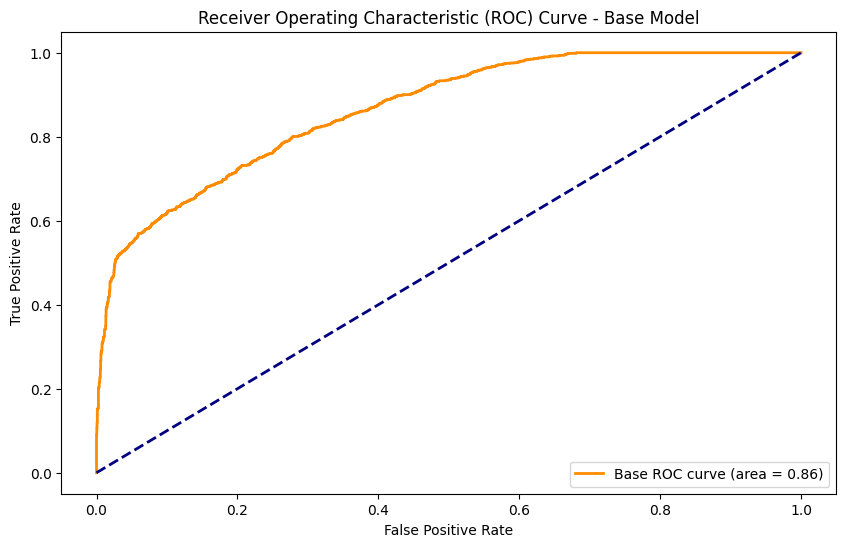

In [12]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, auc

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Apply the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print("Optimal Threshold Model Performance:")
print(classification_report(y_test, y_pred_optimal))
print(confusion_matrix(y_test, y_pred_optimal))

# Plot ROC curve for base model
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba)
roc_auc_base = auc(fpr_base, tpr_base)

plt.figure(figsize=(10, 6))
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2, label=f'Base ROC curve (area = {roc_auc_base:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Base Model')
plt.legend(loc='lower right')
plt.show()

### Testing

In [38]:
test_df = pd.read_csv("test.csv")
#test_df = pd.read_csv("Test2.csv")
validation_df = test_df.loc[test_df['repays_debt'] != '??'] # 2nd validation set 
#testing_df = test_df.loc[test_df['repays_debt'] == '??']# Actual test set

features = numerical_features + [categorical_feature]

# Split validation and testing data into features (X) and target (y) if applicable
X_validation = validation_df.loc[:, features]
y_validation = validation_df['repays_debt'].astype(int)  

X_testing = testing_df.loc[:, features]  

# Predict on validation set
print("Making predictions on the validation set...")
validation_pred = pipeline.predict(X_validation)

# Print validation performance
print("Validation Set Performance:")
print(classification_report(y_validation, validation_pred))
print(confusion_matrix(y_validation, validation_pred))

# Predict on test set
print("Making predictions on the test set...")
testing_pred = pipeline.predict(X_testing)

# Convert predictions to a DataFrame to display
testing_df['repays_debt_pred'] = testing_pred

# Print test set predictions
print("Test Set Predictions:")
print(testing_df[['repays_debt_pred']])

# Optionally, save test set predictions to a CSV file
testing_df[['Label']].to_csv('test_set_predictions.csv', index=False)

Making predictions on the validation set...
Validation Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5054
           1       0.67      0.77      0.72      2118

    accuracy                           0.82      7172
   macro avg       0.78      0.81      0.79      7172
weighted avg       0.83      0.82      0.82      7172

[[4252  802]
 [ 486 1632]]
Making predictions on the test set...
Test Set Predictions:
      repays_debt_pred
9                    0
17                   0
26                   0
35                   0
46                   0
...                ...
7853                 0
7861                 0
7873                 0
7881                 1
7889                 0

[718 rows x 1 columns]


KeyError: "None of [Index(['Label'], dtype='object')] are in the [columns]"

In [24]:
testing_df[['Label']].to_csv('test_set_predictions.csv', index=False)

KeyError: "None of [Index(['Label'], dtype='object')] are in the [columns]"

In [15]:

features = numerical_features + [categorical_feature]

# Split validation and testing data into features (X) and target (y) if applicable
X_validation = validation_df.loc[:, features]
y_validation = validation_df['repays_debt'].astype(int)  # Ensure target is integer

X_testing = testing_df.loc[:, features]  # No y as it's the actual test set

# Predict on the validation set
print("Making predictions on the validation set...")
validation_pred = pipeline.predict(X_validation)

# Print validation performance
print("Validation Set Performance:")
print(classification_report(y_validation, validation_pred))
print(confusion_matrix(y_validation, validation_pred))

# Predict on the test set
print("Making predictions on the test set...")
testing_pred = pipeline.predict(X_testing)

# Rename the predictions column to 'Label'
testing_df['Label'] = testing_pred

# Print test set predictions with the new column name
print("Test Set Predictions with 'Label':")
print(testing_df[['Label']])

# Save test set predictions to a CSV file with the renamed column
testing_df[['Label']].to_csv('test_set_predictions.csv', index=False)


Making predictions on the validation set...
Validation Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5054
           1       0.84      0.78      0.81      2118

    accuracy                           0.89      7172
   macro avg       0.87      0.86      0.87      7172
weighted avg       0.89      0.89      0.89      7172

[[4731  323]
 [ 459 1659]]
Making predictions on the test set...
Test Set Predictions with 'Label':
      Label
9         0
17        0
26        0
35        0
46        0
...     ...
7853      1
7861      0
7873      1
7881      1
7889      1

[718 rows x 1 columns]


/tmp/ipykernel_992/1156259124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['Label'] = testing_pred


In [16]:
tia = pd.read_csv("test_set_predictions.csv")

In [18]:
tia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Label   718 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [20]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

[0.00639735 0.00809545 0.00560421 0.00502768 0.00510172 0.00700748
 0.0067571  0.02527406 0.00636043 0.01279114 0.00808227 0.00817481
 0.00506042 0.00746324 0.01268673 0.00569914 0.01644502 0.02431599
 0.0689267  0.0193885  0.01551608 0.         0.1476524  0.
 0.00318727 0.00346661 0.00599629 0.         0.         0.0024104
 0.0108802  0.00496305 0.08996677 0.00485693 0.00563034 0.00435194
 0.00079966 0.         0.02189386 0.00668528 0.0134352  0.01826339
 0.00459469 0.37079027]


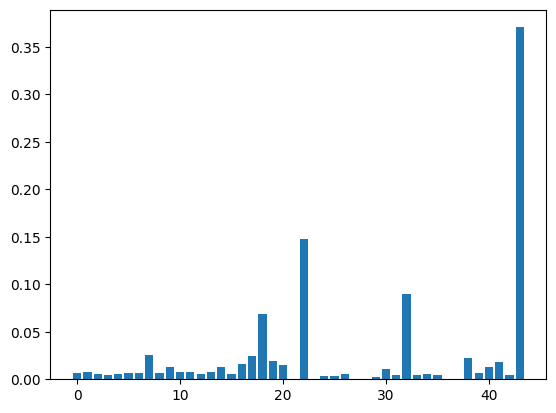

In [23]:
from matplotlib import pyplot

print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [26]:
features = numerical_features + [categorical_feature]  # Replace with your actual feature list

# Get feature importances from the model
importances = model.feature_importances_

# Check if the number of features matches the length of importances
if len(features) == len(importances):
    # Create a DataFrame to combine features and importances
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })

    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance from XGBoost Model')
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.show()

else:
    print("The number of features does not match the length of feature importances.")
    print(f"Number of features: {len(features)}, Number of importances: {len(importances)}")

The number of features does not match the length of feature importances.
Number of features: 42, Number of importances: 44


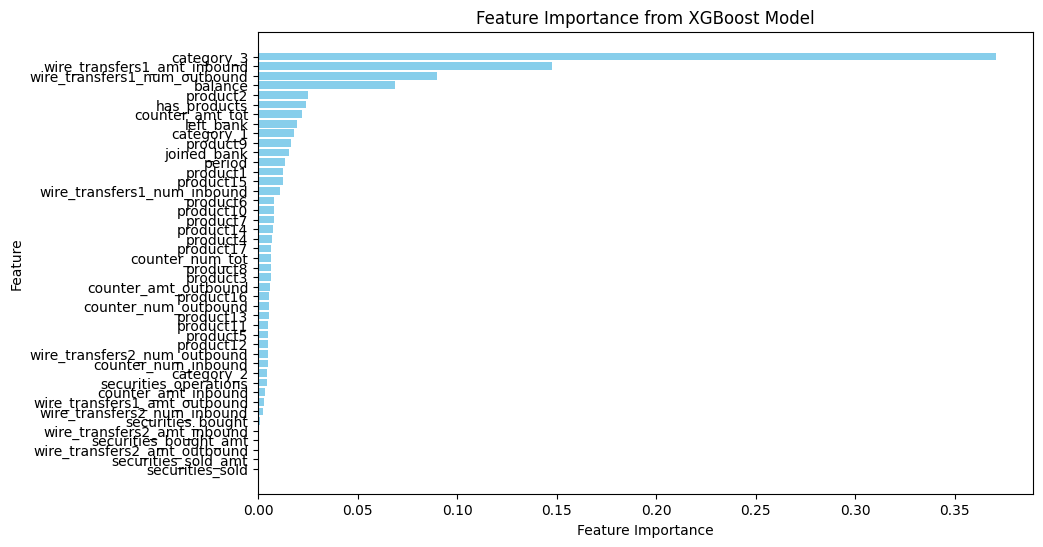

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from matplotlib import pyplot as plt

# Assuming you have a pipeline named 'pipeline' with preprocessor
# This part of the code assumes that your pipeline variable is defined
# Update 'preprocessor' to your actual preprocessor object if it's named differently

# Get feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_feature):
    # Get numerical feature names
    num_features = numerical_features
    
    # Get categorical feature names
    cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out([categorical_feature])
    
    # Combine numerical and categorical features
    all_features = list(num_features) + list(cat_features)
    
    return all_features

# Get feature names
all_features = get_feature_names(preprocessor, numerical_features, categorical_feature)

# Get feature importances
importances = model.feature_importances_

# Check if the number of features matches the length of importances
if len(all_features) == len(importances):
    # Create a DataFrame to combine features and importances
    feature_importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    })

    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance from XGBoost Model')
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.show()

else:
    print("The number of features does not match the length of feature importances.")
    print(f"Number of features: {len(all_features)}, Number of importances: {len(importances)}")
